In [1]:
%autosave 0
import numpy as np
import pandas as pd

Autosave disabled


# <center>Data Overview</center>

In [2]:
# https://www.kaggle.com/datasets/mukeshmanral/univariate-time-series
ts = pd.read_csv('date_count.csv')

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    578 non-null    object
 1   count   578 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


In [4]:
ts

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


### Preprocessing

In [5]:
ts['Date'] = pd.to_datetime(ts['Date'])
ts.set_index('Date', inplace=True)

### Time series plot

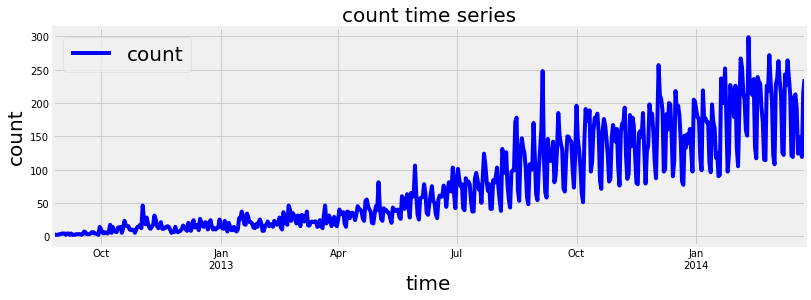

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

ts.plot(color='blue')
plt.title('count time series', size=20)
plt.xlabel('time', size=20)
plt.ylabel('count', size = 20)
plt.gcf().set_size_inches(12, 4)
plt.legend(loc=2, prop={'size': 20})

### Time series decomposition

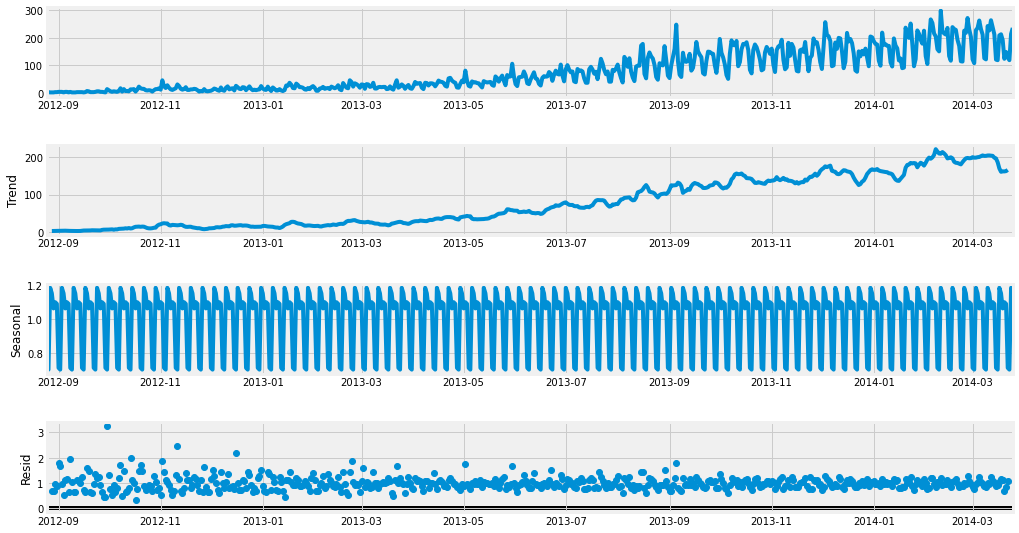

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.asfreq('D')
decompose = seasonal_decompose(ts, model='multiplicative')
decompose.plot()
plt.gcf().set_size_inches(16, 8)
plt.show()

Let's have a closer look at the seasonality.

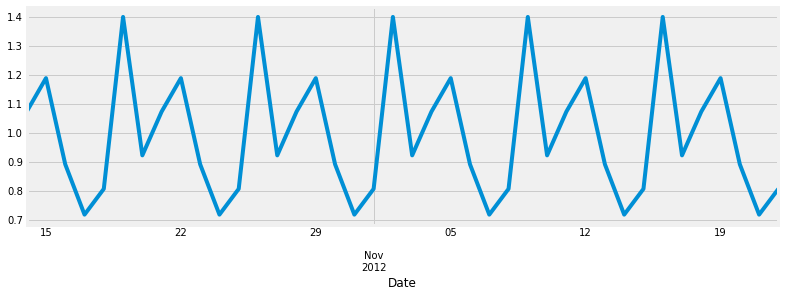

In [8]:
magified_seasonality = ts.iloc[50:90]
magified_seasonality.asfreq('D')
decomp = seasonal_decompose(magified_seasonality, model='multiplicative')
decomp.seasonal.plot()
plt.gcf().set_size_inches(12, 4)
plt.show()

It is now evident that weekly seasonality is present.

# <center>Multi-step 60-day forecast (fh = 60)</center>

### Train / test split

In [9]:
y_train = ts[:len(ts)-60]
y_test = ts[len(ts)-60:]

### Training the model

In [10]:
# NeuralProphet expects 2 columns with predefined names and formats (namely: ds, datetime and y, pd.Series)
y_train.reset_index(inplace=True)
y_train.columns = ['ds','y']

In [11]:
from neuralprophet import NeuralProphet

m = NeuralProphet(seasonality_mode="multiplicative")
model = m.fit(y_train, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 243


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.14E-01, min: 8.90E-02


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.41E-02, min: 1.26E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.39E-01
Epoch[243/243]: 100%|██████████| 243/243 [00:09<00:00, 25.88it/s, SmoothL1Loss=0.00368, MAE=10.1, RMSE=14.6, RegLoss=0]


### Forecasting

In [12]:
future = m.make_future_dataframe(y_train, periods=60)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [13]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             60 non-null     datetime64[ns]
 1   y              0 non-null      object        
 2   yhat1          60 non-null     float64       
 3   residual1      0 non-null      object        
 4   trend          60 non-null     float64       
 5   season_weekly  60 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.9+ KB


In [14]:
forecast.head()

,ds,y,yhat1,residual1,trend,season_weekly
0,2014-01-25,None,105.006088,NaN,164.141708,-0.364716
1,2014-01-26,None,98.170677,NaN,164.410889,-0.407856
2,2014-01-27,None,190.946411,NaN,164.680099,0.161460
3,2014-01-28,None,198.852371,NaN,164.949280,0.208059
4,2014-01-29,None,191.954636,NaN,165.218491,0.163806


### Evaluation

In [15]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2014-01-25 to 2014-03-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [16]:
forecast.set_index('ds', inplace=True)
evaluation_df = forecast.assign(y_test=y_test['count'])
evaluation_df.rename(columns={'yhat1':'y_pred'}, inplace=True)

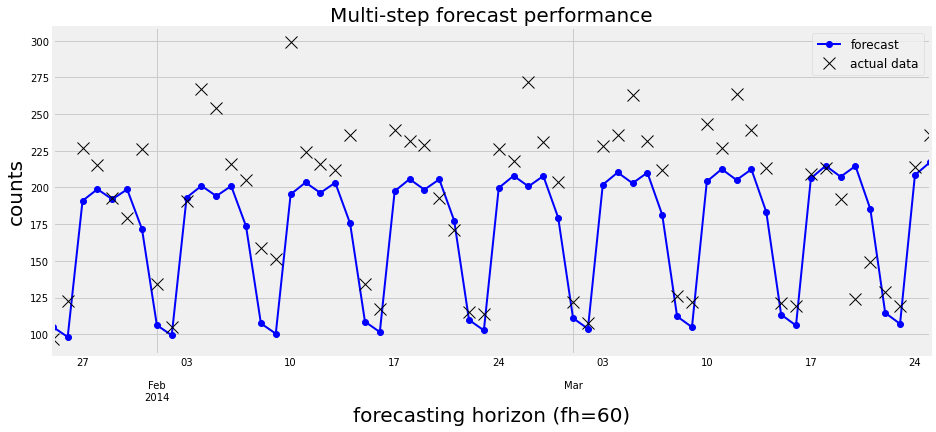

In [17]:
plt.figure()
evaluation_df['y_pred'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.title('Multi-step forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=60)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=1, prop={'size': 12})

It is time for the final straw, evaluation in terms of metrics.

In [18]:
def evaluation_metrics(y_test, y_pred, model_name):
    MAPE = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'Model':model_name, 'MAPE':round(MAPE,3), 'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

In [19]:
accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['y_pred'], 'NeuralProphet')
print(accuracy)

{'Model': 'NeuralProphet', 'MAPE': 13.848, 'RMSE': 34.681, 'MAE': 26.848}


In [20]:
performance_summary_fh60 = pd.read_csv('performance_summary_fh60.csv')
performance_summary_fh60 = performance_summary_fh60.append(accuracy, ignore_index=True)
performance_summary_fh60.to_csv('performance_summary_fh60.csv', index=False)